<a href="https://colab.research.google.com/github/kabir-kj/Facial-Emotion-Recognition/blob/main/Facial_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install tensorflow keras opencv-python-headless


In [15]:
#Data Collection and Preprocessing
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

# Load the dataset
filname = '/content/drive/MyDrive/fer2013/fer2013.csv'
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']
df = pd.read_csv('/content/drive/MyDrive/fer2013/fer2013.csv',names=names, na_filter=False)
im=df['pixels']

# Split the data into training, validation, and test sets
def getData(filname):
    # images are 48x48
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y

X, Y = getData(filname)
num_class = len(set(Y))

N, D = X.shape
X = X.reshape(N, 48, 48, 1)

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
#feature extraction and model build
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from keras.optimizers import *


def my_model():
    model = Sequential()
    input_shape = (48,48,1)
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    # UNCOMMENT THIS TO VIEW THE ARCHITECTURE
    #model.summary()

    return model
model=my_model()
model.summary()

path_model='/content/drive/MyDrive/fer2013/emotion_detect.h5' # save model at this location after each epoch
K.clear_session()  # Destroys the current graph and builds a new one
model=my_model() # create the model
K.set_value(model.optimizer.lr, 1e-3)  # Set the learning rate
# fit the model
h=model.fit(x=X_train,
            y=y_train,
            batch_size=64,
            epochs=20,
            verbose=1,
            validation_data=(X_test,y_test),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model,save_best_only=True),
            ]
            )



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_4 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 128)      

In [20]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
y_pos = np.arange(len(objects))
print(y_pos)

[0 1 2 3 4 5 6]


In [21]:
def emotion_analysis(emotions):
    objects = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')

plt.show()

In [22]:
y_pred=model.predict(X_test)
#print(y_pred)
y_test.shape


113/113 [==============================] - 1s 6ms/step


(3589, 7)

1/1 [==============================] - 0s 18ms/step


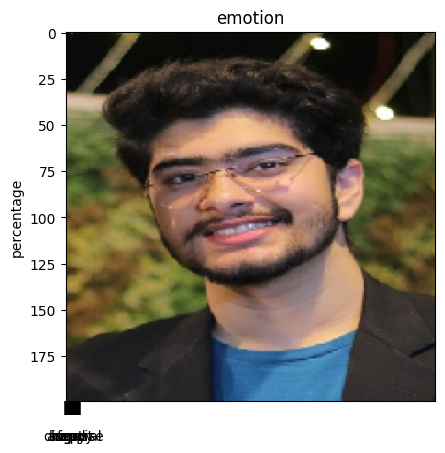

Expression Prediction: happy


In [30]:
from skimage import io
img = image.load_img('/content/img.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('/content/img.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i

print('Expression Prediction:',objects[ind])

1/1 [==============================] - 0s 88ms/step


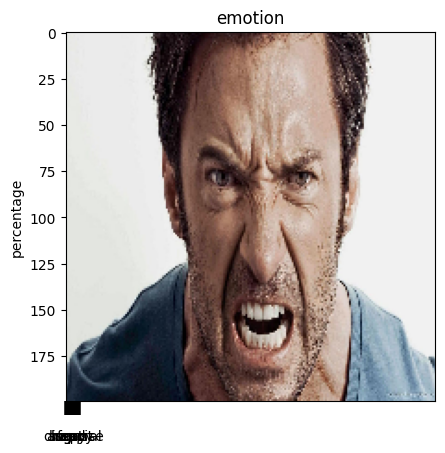

Expression Prediction: angry


In [31]:
from skimage import io
img = image.load_img('/content/img2.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('/content/img2.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i

print('Expression Prediction:',objects[ind])